In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import re
from plotly import graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer  # -- Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer  # -- Tf-Idf
from sklearn.decomposition import TruncatedSVD  # -- SVD
from sklearn.svm import SVC  # -- SVM
from sklearn.model_selection import train_test_split  # -- Split Dataset
from sklearn.metrics import classification_report  # -- Model Summary
from sklearn.ensemble import RandomForestClassifier  # -- Random Forest
from sklearn.cluster import KMeans  # -- K-means Algorithm
from sklearn.metrics import confusion_matrix  # -- Confusion Matrix
from sklearn.metrics.cluster import normalized_mutual_info_score  # -- Mutual Information Score
from sklearn.cluster import AgglomerativeClustering  # -- Hierarchical
from sklearn.neighbors import KNeighborsClassifier  # -- knn
import nltk
nltk.download('punkt')

KeyboardInterrupt: 

# LETTURA DATA SET

In [2]:
data_path = 'data/english_news.csv'
data_eng = pd.read_csv(data_path, sep ='\t')
data_eng.sample(2)

,source,date,title,author,text
33005,The Japan Times,2008-01-03,Second fire hits historic residence of U.S. ar...,NaN,YOKOHAMA –The historic residence of the late U...
25941,The Japan Times,2003-04-28,Satake turns out Castanares' lights,NaN,"Masakazu Satake, one of Japan’s hottest boxing..."


# ELIMINAZIONE VALORI NULLI E DUPLICATI

In [3]:
data_eng.describe()

,source,date,title,author,text
count,36889,36889,36889,12846,36766
unique,2,1504,36059,1318,35932
top,The Japan Times,2003-06-06,KANSAI: Who & What,Philip Brasor,This could be due to a conflict with your ad-b...
freq,36815,66,23,318,5


In [4]:
data_eng.groupby('source').describe()

date                          title         \
                  count unique         top freq  count unique   
source                                                          
Mainichi Shimbun     74     60  2021-12-08    3     74     74   
The Japan Times   36815   1448  2003-06-06   66  36815  35985   

                                                                          \
                                                                top freq   
source                                                                     
Mainichi Shimbun  Jonathan Bush, brother of President George H.W...    1   
The Japan Times                                  KANSAI: Who & What   23   

                 author                              text         \
                  count unique            top freq  count unique   
source                                                             
Mainichi Shimbun      1      1            By     1     74     74   
The Japan Times   12845   1317  Philip Brasor  318  36692  35858   

                                                                          
                                                                top freq  
source                                                                    
Mainichi Shimbun  The Japanese government has finalized its dama...    1  
The Japan Times     This could be due to a conflict with your ad...    5

# ANALISI DESCRITTIVA

In [5]:
data_eng_clean = data_eng.dropna(subset=['text'])
df_clean= data_eng_clean.drop_duplicates(subset='text', keep=False)

In [6]:
# convert type to a numerical variable
df_clean['type_num'] = df_clean.source.map({'Mainichi Shimbun':0, 'The Japan Times':1})
df_clean.head()

<ipython-input-6-e109327d775d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['type_num'] = df_clean.source.map({'Mainichi Shimbun':0, 'The Japan Times':1})


,source,date,title,author,text,type_num
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...,0
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public...",0
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...,0
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was...",0
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...,0


In [8]:
df_clean.groupby('source').describe()

type_num                                   
                    count mean  std  min  25%  50%  75%  max
source                                                      
Mainichi Shimbun     74.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
The Japan Times   35218.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [ ]:
df_clean['n_characters'] = df_clean['text'].str.len()
df_clean['n_words']      = df_clean['text'].str.split().str.len()

<ipython-input-9-e84c8c056e7a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['text_len'] = df_clean.text.apply(len)
<ipython-input-9-e84c8c056e7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Numero_di_parole'] = df_clean['text'].str.split().str.len()


In [10]:
balance_counts = df_clean.groupby('source')['source'].agg('count').values
balance_counts

array([   74, 35218], dtype=int64)

In [11]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Mainichi Shimbun'],
    y=[balance_counts[0]],
    name='Mainichi Shimbun',
    text=[balance_counts[0]],
    textposition='auto',
))
fig.add_trace(go.Bar(
    x=['The Japan Times'],
    y=[balance_counts[1]],
    name='The Japan Times',
    text=[balance_counts[1]],
    textposition='auto'
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Distribuzione dei Giornali</span>'
)
fig.show()

Text(0.5, 0, 'Numero di Parole')

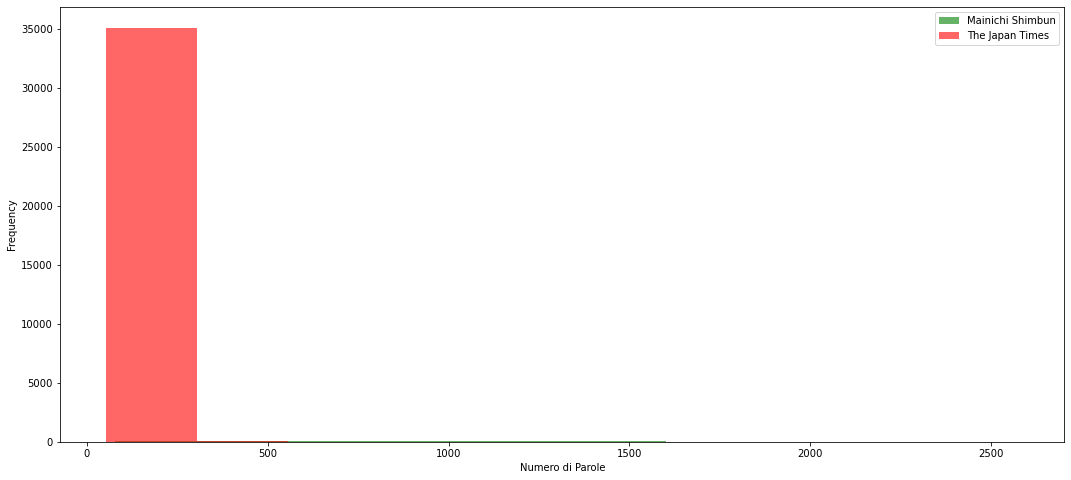

In [12]:
plt.figure(figsize=(18, 8))

df_clean[df_clean.source=='Mainichi Shimbun'].Numero_di_parole.plot(bins=1, kind='hist', color='green',
                                       label='Mainichi Shimbun', alpha=0.6)
df_clean[df_clean.source=='The Japan Times'].Numero_di_parole.plot(kind='hist', color='red',
                                       label='The Japan Times', alpha=0.6)
plt.legend()
plt.xlabel("Numero di Parole")

In [13]:
df_clean[df_clean.source=='Mainichi Shimbun'].describe()

,type_num,text_len,Numero_di_parole
count,74.0,74.000000,74.000000
mean,0.0,3597.837838,591.662162
std,0.0,2170.716535,362.978179
min,0.0,458.000000,78.000000
25%,0.0,2269.250000,368.750000
50%,0.0,3175.500000,515.500000
75%,0.0,3911.000000,644.750000
max,0.0,9842.000000,1600.000000


In [14]:
df_clean[df_clean.source=='The Japan Times'].describe()

,type_num,text_len,Numero_di_parole
count,35218.0,35218.000000,35218.000000
mean,1.0,794.545091,127.760946
std,0.0,270.531434,44.831390
min,1.0,333.000000,52.000000
25%,1.0,667.000000,106.000000
50%,1.0,737.000000,118.000000
75%,1.0,838.000000,135.000000
max,1.0,15605.000000,2577.000000


# PRE- PROCCESSING

In [15]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_punctuation(text, punctuation=None):
    if punctuation is None:
        punctuation = string.punctuation
    return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))

def remove_stopwords(text, stopwords=None):
    if stopwords is None:
        stopwords = STOPWORDS
    return ' '.join([word for word in text.split() if word not in stopwords])

def remove_extra_whitespace(text):
    return " ".join(text.split())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Federico\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [16]:
df_clean

,source,date,title,author,text,type_num,text_len,Numero_di_parole
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...,0,3442,567
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public...",0,3489,540
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...,0,3178,522
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was...",0,2823,472
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...,0,3841,620
...,...,...,...,...,...,...,...,...
36884,The Japan Times,2021-06-06,COVID-19 tracker: Tokyo reports 351 new cases ...,NaN,Tokyo confirmed 351 new cases of COVID-19 on S...,1,567,88
36885,The Japan Times,2021-06-07,Dollar weakens to around ¥109.40 in Tokyo,NaN,The dollar eased to around ¥109.40 in Tokyo tr...,1,591,100
36886,The Japan Times,2021-06-07,"Nikkei ends higher, but gains limited",NaN,The benchmark Nikkei average turned higher on ...,1,637,108
36887,The Japan Times,2021-06-07,COVID-19 tracker: Osaka reports 72 new cases b...,NaN,Osaka Prefecture reported 72 new COVID-19 case...,1,729,118


In [17]:
df_clean["clean_text"] = df_clean.text.str.lower()
df_clean['clean_text'] = df_clean.clean_text.apply(remove_numbers)
df_clean['clean_text'] = df_clean.clean_text.apply(remove_punctuation)
df_clean['clean_text'] = df_clean.clean_text.apply(remove_stopwords)
df_clean['clean_text'] = df_clean.clean_text.apply(remove_extra_whitespace)

<ipython-input-17-0f37e50a7a5c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-0f37e50a7a5c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-0f37e50a7a5c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-0f37e50

# STEMMING

In [18]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [19]:
df_clean['clean_text'] = df_clean['clean_text'].apply(stemm_text)
df_clean.head()

<ipython-input-19-546bed8bc651>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,source,date,title,author,text,type_num,text_len,Numero_di_parole,clean_text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...,0,3442,567,japanes govern tri boost uptak number person i...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public...",0,3489,540,prime minist fumio kishida public mandat admin...
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...,0,3178,522,year sinc start pacif war imperi japanes milit...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was...",0,2823,472,world chang complet era enorm sever came yeste...
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...,0,3841,620,administr presid joe biden decid diplomat boyc...


# TOKEN

In [20]:
df_clean["tokens"] = df_clean.clean_text.str.split()
df_clean

<ipython-input-20-f8e022877fbc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,source,date,title,author,text,type_num,text_len,Numero_di_parole,clean_text,tokens
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...,0,3442,567,japanes govern tri boost uptak number person i...,"[japanes, govern, tri, boost, uptak, number, p..."
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public...",0,3489,540,prime minist fumio kishida public mandat admin...,"[prime, minist, fumio, kishida, public, mandat..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...,0,3178,522,year sinc start pacif war imperi japanes milit...,"[year, sinc, start, pacif, war, imperi, japane..."
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was...",0,2823,472,world chang complet era enorm sever came yeste...,"[world, chang, complet, era, enorm, sever, cam..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...,0,3841,620,administr presid joe biden decid diplomat boyc...,"[administr, presid, joe, biden, decid, diploma..."
...,...,...,...,...,...,...,...,...,...,...
36884,The Japan Times,2021-06-06,COVID-19 tracker: Tokyo reports 351 new cases ...,NaN,Tokyo confirmed 351 new cases of COVID-19 on S...,1,567,88,tokyo confirm new case covid sunday hard hit o...,"[tokyo, confirm, new, case, covid, sunday, har..."
36885,The Japan Times,2021-06-07,Dollar weakens to around ¥109.40 in Tokyo,NaN,The dollar eased to around ¥109.40 in Tokyo tr...,1,591,100,dollar eas around ¥ tokyo trade monday search ...,"[dollar, eas, around, ¥, tokyo, trade, monday,..."
36886,The Japan Times,2021-06-07,"Nikkei ends higher, but gains limited",NaN,The benchmark Nikkei average turned higher on ...,1,637,108,benchmark nikkei averag turn higher monday tha...,"[benchmark, nikkei, averag, turn, higher, mond..."
36887,The Japan Times,2021-06-07,COVID-19 tracker: Osaka reports 72 new cases b...,NaN,Osaka Prefecture reported 72 new COVID-19 case...,1,729,118,osaka prefectur report new covid case monday f...,"[osaka, prefectur, report, new, covid, case, m..."


In [21]:
from collections import Counter

words = df_clean[df_clean.source=='The Japan Times'].clean_text.apply(lambda x: [word.lower() for word in x.split()])
The_Japan_Times = Counter()

for msg in words:
    The_Japan_Times.update(msg)

print(The_Japan_Times.most_common(50))

[('pleas', 70580), ('co', 38275), ('issu', 37079), ('secur', 36948), ('could', 36937), ('support', 36754), ('due', 36315), ('allow', 36287), ('see', 36241), ('list', 35879), ('ad', 35868), ('site', 35857), ('conflict', 35526), ('resolv', 35467), ('apolog', 35448), ('page', 35444), ('softwar', 35430), ('unabl', 35414), ('block', 35408), ('add', 35383), ('humbl', 35278), ('domain', 35271), ('inconveni', 35262), ('addjapantim', 35246), ('jpandpiano', 35246), ('ioto', 35246), ('allowlist', 35246), ('outthi', 35246), ('said', 19092), ('japan', 15284), ('year', 14402), ('—', 11080), ('”', 9514), ('japanes', 8096), ('tokyo', 7269), ('govern', 6645), ('new', 6574), ('first', 6479), ('one', 6142), ('two', 6091), ('yen', 5629), ('offici', 5593), ('world', 5352), ('minist', 5171), ('nation', 5162), ('time', 4637), ('prefectur', 4472), ('percent', 4455), ('last', 4379), ('friday', 4164)]


In [22]:
from collections import Counter

words = df_clean[df_clean.source=='Mainichi Shimbun'].clean_text.apply(lambda x: [word.lower() for word in x.split()])
Mainichi_Shimbun= Counter()

for msg in words:
    Mainichi_Shimbun.update(msg)

print(Mainichi_Shimbun.most_common(50))

[('said', 185), ('year', 148), ('govern', 135), ('japan', 122), ('time', 114), ('peopl', 112), ('would', 109), ('also', 98), ('first', 92), ('countri', 89), ('one', 87), ('parti', 86), ('presid', 84), ('includ', 76), ('die', 76), ('south', 73), ('state', 72), ('new', 69), ('work', 69), ('nation', 63), ('famili', 60), ('two', 59), ('public', 58), ('world', 58), ('polit', 58), ('watt', 58), ('minist', 57), ('made', 56), ('member', 56), ('call', 55), ('japanes', 54), ('mani', 53), ('like', 53), ('olymp', 53), ('de', 51), ('could', 49), ('death', 49), ('play', 49), ('make', 48), ('later', 46), ('need', 45), ('prime', 45), ('use', 44), ('power', 44), ('right', 44), ('game', 44), ('war', 43), ('becam', 43), ('ever', 43), ('take', 42)]


# text representation

In [23]:
x = df_clean.clean_text
y = df_clean.type_num
print(x.shape)
print(y.shape)

(35292,)
(35292,)


## bag of words

In [24]:
vect = CountVectorizer(max_features=30000)
X_bow = vect.fit_transform(df_clean['clean_text'])
X_bow

<35292x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 2413249 stored elements in Compressed Sparse Row format>

## Binary

In [25]:
vect = CountVectorizer(binary = True)
X_bin = vect.fit_transform(df_clean['clean_text'])
X_bin

<35292x46381 sparse matrix of type '<class 'numpy.int64'>'
	with 2429630 stored elements in Compressed Sparse Row format>

## TF - IDF

In [26]:
vect = TfidfVectorizer(max_features=10000)
X_tfidf = vect.fit_transform(df_clean['clean_text'])
X_tfidf

<35292x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2351824 stored elements in Compressed Sparse Row format>

In [27]:
def classification_SVM(X, score, txt_rep):
    X_train, X_test, y_train, y_test = train_test_split(X,  # Text dataset
                                                        score,  # score set
                                                        test_size=0.30,  # split size
                                                        random_state=50)  #  set seed
    clf = SVC().fit(X_train, y_train)  #  SVM
    y_pred = clf.predict(X_test)
    print('SVM ' + txt_rep)
    print(classification_report(y_test, y_pred))  #  report
    return 0

In [28]:
def SVD(x):
    svd_decomposer = TruncatedSVD(n_components=100,
                                  n_iter=10)
    df = svd_decomposer.fit_transform(x)
    return df

In [29]:
def classification_KNN(X, score, txt_rep):
    X_train, X_test, y_train, y_test = train_test_split(X,  # Text dataset
                                                        score,  # score set
                                                        test_size=0.30,  # split size
                                                        random_state=50)  # set seed
    knn = KNeighborsClassifier(n_neighbors=5,
                               n_jobs=-1).fit(X_train, y_train)  # kNN
    y_pred = knn.predict(X_test)
    print('KNN ' + txt_rep)
    print(classification_report(y_test, y_pred))  # report
    return 0

In [30]:
def classification_RandomForest(X, score, txt_rep):
    X_train, X_test, y_train, y_test = train_test_split(X,  # Text dataset
                                                        score,  # score set
                                                        test_size=0.30,  # split size
                                                        random_state=50)  # set seed
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)  # Random Forest
    y_pred = rf.predict(X_test)
    print('Random Forest ' + txt_rep)
    print(classification_report(y_test, y_pred))  # report
    return 0

In [31]:
X_bow = SVD(X_bow)
print("SVD bag of words")
X_bin = SVD(X_bin)
print("SVD Binary")
X_tfidf = SVD(X_tfidf)
print("SVD TF IDF")
classification_SVM(X_bow, df_clean['source'], 'Bag Of Words')
classification_SVM(X_tfidf, df_clean['source'], 'TF-IDF')
classification_SVM(X_bin, df_clean['source'], 'Binary')
classification_KNN(X_bow, df_clean['source'], 'Bag Of Words')
classification_KNN(X_tfidf, df_clean['source'], 'TF-IDF')
classification_KNN(X_bin, df_clean['source'], 'Binary')
classification_RandomForest(X_bow, df_clean['source'], 'Bag Of Words')
classification_RandomForest(X_tfidf, df_clean['source'], 'TF-IDF')
classification_RandomForest(X_bin, df_clean['source'], 'Binary')

SVD bag of words
SVD Binary
SVD TF IDF
SVM Bag Of Words
                  precision    recall  f1-score   support

Mainichi Shimbun       1.00      0.07      0.13        14
 The Japan Times       1.00      1.00      1.00     10574

        accuracy                           1.00     10588
       macro avg       1.00      0.54      0.57     10588
    weighted avg       1.00      1.00      1.00     10588

SVM TF-IDF
                  precision    recall  f1-score   support

Mainichi Shimbun       1.00      0.07      0.13        14
 The Japan Times       1.00      1.00      1.00     10574

        accuracy                           1.00     10588
       macro avg       1.00      0.54      0.57     10588
    weighted avg       1.00      1.00      1.00     10588

SVM Binary
                  precision    recall  f1-score   support

Mainichi Shimbun       0.69      0.64      0.67        14
 The Japan Times       1.00      1.00      1.00     10574

        accuracy                           1

0

### CLUSTER

In [32]:
def clustering_kmeans(X, score, txtp_rep):
    kmeans = KMeans(n_clusters=2).fit(X) # Number of clusters to find
    cluster_kmeans = kmeans.labels_
    print('\nK Means ' + txtp_rep)
    print(confusion_matrix(score, cluster_kmeans))  # Confusion Matrix

    print('K Means ' + txtp_rep+' Mutual Informatione Score : ' +str(normalized_mutual_info_score(score,
                                       cluster_kmeans)))  # Mutual Information Score

In [33]:
def clustering_hier(X, score, txtp_rep):
    agglomerative = AgglomerativeClustering(distance_threshold=None,
                                            n_clusters=2, # Number of clusters to find
                                            affinity='euclidean',  # Similarity measure
                                            linkage='ward').fit(X  )  # Linkage method
    labels_agglomerative = agglomerative.labels_
    print('\nHierarchical ' + txtp_rep)
    print(confusion_matrix(score, labels_agglomerative))  # Confusion Matrix

    print('Hierarchical '+ txtp_rep+' Mutual Informatione Score : ' +str(normalized_mutual_info_score(score,
                                       labels_agglomerative)))  # Mutual Information Score

In [34]:
clustering_kmeans(X_bow, df_clean['type_num'], 'Bag Of Words')
clustering_kmeans(X_tfidf, df_clean['type_num'], 'TF-IDF')
clustering_kmeans(X_bin, df_clean['type_num'], 'Binary')


K Means Bag Of Words
[[   27    47]
 [13138 22080]]
K Means Bag Of Words Mutual Informatione Score : 8.894277239999418e-07

K Means TF-IDF
[[    2    72]
 [ 4267 30951]]
K Means TF-IDF Mutual Informatione Score : 0.0006376482447543764

K Means Binary
[[   73     1]
 [21261 13957]]
K Means Binary Mutual Informatione Score : 0.0026777460172337383


In [35]:
clustering_hier(X_bow, df_clean['type_num'], 'Bag Of Words')
clustering_hier(X_tfidf, df_clean['type_num'], 'TF-IDF')
clustering_hier(X_bin, df_clean['type_num'], 'Binary')